In [1]:
import os.path as osp
import torch.nn as nn
import torch
from focal_loss.focal_loss import FocalLoss

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
import pandas as pd
from performance import performances_val
from PIL import Image
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.data import Data
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import ChebConv, GraphSAGE,GraphUNet ,TransformerConv

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed = 1378
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
landmark_colors = np.load("landmark_colors.npy")
from sklearn.preprocessing import OneHotEncoder
one_hot_list=[]
enc = OneHotEncoder()
enc.fit(np.expand_dims(landmark_colors,axis=1))  
for x in landmark_colors:
    one_hot_list.append(enc.transform([[x]]).toarray()[0])
one_hot_arr  = np.array(one_hot_list)
one_hot_arr = torch.FloatTensor(one_hot_arr)

m = torch.nn.Softmax(dim=-1)

class landmark_dataset(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        
        data = torch.load(graph_path)
        #data.x =data.x.t()
        return data 
class landmark_dataset_train(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        data = torch.load(graph_path)
        
 
        
        domain_name = graph_path.split("/")[-4]
        
            
        if domain_name == "MSU_MFSD" :
            
            domain_label = 0
            
        elif domain_name == "Replay_attack_dataset" :
            
            domain_label = 1
        else :
            print(graph_path,domain_name )
            raise "error"
            
        
        data = Data(x=data.x, edge_index=data.edge_index,y =data.y,data = domain_label,y_node = one_hot_arr)

        #data.x =data.x.t()
        return data 
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=16,pin_memory=True)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_O.txt")
test_loader = DataLoader(test_dataset, batch_size=64,num_workers=16)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
#sequence_length = 128
#feature_dim = 4  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead,n_out):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(4, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(128 * embed_dim, n_out)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
sequence_length = 128
feature_dim = 1  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer_2(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead):
        super(SimpleTransformer_2, self).__init__()
        self.linear = nn.Linear(feature_dim, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequence_length * embed_dim, 7)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [2]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 2
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,2)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= m(x)
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= FocalLoss(gamma=2)
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y)  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            #print(logit.shape)
            logit = logit[:,1]
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [3]:
best_auc = 0
for epoch in range(0, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'two_domain_M_I_to_O_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue 

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.00batch/s]


/////////////////////////
adverserial loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(0.0002, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0127, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0132, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:33<00:00,  7.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_1/score.txt
epoch:1, test:  val_ACC=0.6454, HTER=0.3546, AUC=0.6854, val_err=0.3546, ACC=0.6454, TPR=0.0419
improve acc .. .. ..


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:23<00:00,  5.96batch/s]


/////////////////////////
adverserial loss :  tensor(6.9240e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8870e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0053, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0053, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:48<00:00,  7.37batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_2/score.txt
epoch:2, test:  val_ACC=0.6573, HTER=0.3427, AUC=0.7176, val_err=0.3427, ACC=0.6573, TPR=0.1372
improve acc .. .. ..


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:25<00:00,  5.90batch/s]


/////////////////////////
adverserial loss :  tensor(8.3071e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6674e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0044, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0045, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:34<00:00,  7.75batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_3/score.txt
epoch:3, test:  val_ACC=0.6729, HTER=0.3271, AUC=0.7277, val_err=0.3271, ACC=0.6729, TPR=0.1383
improve acc .. .. ..


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:23<00:00,  5.95batch/s]


/////////////////////////
adverserial loss :  tensor(9.8845e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5226e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0038, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0038, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:35<00:00,  7.74batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_4/score.txt
epoch:4, test:  val_ACC=0.6787, HTER=0.3213, AUC=0.7529, val_err=0.3213, ACC=0.6787, TPR=0.2281
improve acc .. .. ..


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:24<00:00,  5.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.1572e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0141e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0034, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0035, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:46<00:00,  7.43batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_5/score.txt
epoch:5, test:  val_ACC=0.6806, HTER=0.3194, AUC=0.7436, val_err=0.3194, ACC=0.6806, TPR=0.1276


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.8227e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3379e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0032, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0032, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:36<00:00,  7.72batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_6/score.txt
epoch:6, test:  val_ACC=0.6861, HTER=0.3139, AUC=0.7523, val_err=0.3139, ACC=0.6861, TPR=0.1908


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.0050e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7928e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0030, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0030, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:42<00:00,  7.54batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_7/score.txt
epoch:7, test:  val_ACC=0.6976, HTER=0.3024, AUC=0.7691, val_err=0.3024, ACC=0.6976, TPR=0.2349
improve acc .. .. ..


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:39<00:00,  5.53batch/s]


/////////////////////////
adverserial loss :  tensor(9.0717e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0740e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0027, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0027, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [05:38<00:00,  6.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_8/score.txt
epoch:8, test:  val_ACC=0.7447, HTER=0.2553, AUC=0.8202, val_err=0.2553, ACC=0.7447, TPR=0.2612
improve acc .. .. ..


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:54<00:00,  5.17batch/s]


/////////////////////////
adverserial loss :  tensor(7.6725e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8794e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0026, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0026, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:30<00:00,  2.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_9/score.txt
epoch:9, test:  val_ACC=0.7547, HTER=0.2453, AUC=0.8461, val_err=0.2453, ACC=0.7547, TPR=0.3338
improve acc .. .. ..


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.25batch/s]


/////////////////////////
adverserial loss :  tensor(1.0209e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0880e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0023, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0023, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:24<00:00,  2.47batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_10/score.txt
epoch:10, test:  val_ACC=0.7444, HTER=0.2556, AUC=0.8275, val_err=0.2556, ACC=0.7444, TPR=0.3051


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.26batch/s]


/////////////////////////
adverserial loss :  tensor(1.5659e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4059e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0022, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0022, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:05<00:00,  2.52batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_11/score.txt
epoch:11, test:  val_ACC=0.7416, HTER=0.2584, AUC=0.8269, val_err=0.2584, ACC=0.7416, TPR=0.3125


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.22batch/s]


/////////////////////////
adverserial loss :  tensor(2.0183e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4580e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0020, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0020, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [13:53<00:00,  2.56batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_12/score.txt
epoch:12, test:  val_ACC=0.6984, HTER=0.3015, AUC=0.7754, val_err=0.3016, ACC=0.6984, TPR=0.2193


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.22batch/s]


/////////////////////////
adverserial loss :  tensor(7.7154e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6247e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0019, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0019, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:23<00:00,  2.47batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_13/score.txt
epoch:13, test:  val_ACC=0.7588, HTER=0.2412, AUC=0.8547, val_err=0.2412, ACC=0.7588, TPR=0.4281
improve acc .. .. ..


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:56<00:00,  5.12batch/s]


/////////////////////////
adverserial loss :  tensor(4.9220e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6033e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0018, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0018, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:26<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_14/score.txt
epoch:14, test:  val_ACC=0.7659, HTER=0.2341, AUC=0.8617, val_err=0.2341, ACC=0.7659, TPR=0.3935
improve acc .. .. ..


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:57<00:00,  5.10batch/s]


/////////////////////////
adverserial loss :  tensor(2.8176e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.3994e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0017, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0017, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:36<00:00,  2.43batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_15/score.txt
epoch:15, test:  val_ACC=0.7672, HTER=0.2327, AUC=0.8471, val_err=0.2328, ACC=0.7672, TPR=0.2814


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.20batch/s]


/////////////////////////
adverserial loss :  tensor(8.7053e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(6.6903e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0016, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0016, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:38<00:00,  2.42batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_16/score.txt
epoch:16, test:  val_ACC=0.7328, HTER=0.2672, AUC=0.8140, val_err=0.2672, ACC=0.7328, TPR=0.2506


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:56<00:00,  5.14batch/s]


/////////////////////////
adverserial loss :  tensor(1.0231e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5262e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0015, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0015, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:26<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_17/score.txt
epoch:17, test:  val_ACC=0.7294, HTER=0.2706, AUC=0.8175, val_err=0.2706, ACC=0.7294, TPR=0.3105


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:48<00:00,  5.30batch/s]


/////////////////////////
adverserial loss :  tensor(1.4325e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5190e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0015, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0015, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:27<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_18/score.txt
epoch:18, test:  val_ACC=0.7560, HTER=0.2440, AUC=0.8374, val_err=0.2440, ACC=0.7560, TPR=0.3238


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:51<00:00,  5.23batch/s]


/////////////////////////
adverserial loss :  tensor(4.3381e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0175e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0014, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0014, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:09<00:00,  2.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_19/score.txt
epoch:19, test:  val_ACC=0.7909, HTER=0.2091, AUC=0.8773, val_err=0.2091, ACC=0.7909, TPR=0.3950
improve acc .. .. ..


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.21batch/s]


/////////////////////////
adverserial loss :  tensor(2.4046e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.3729e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0013, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0013, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:18<00:00,  2.48batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_20/score.txt
epoch:20, test:  val_ACC=0.7639, HTER=0.2361, AUC=0.8467, val_err=0.2361, ACC=0.7639, TPR=0.3272


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:51<00:00,  5.23batch/s]


/////////////////////////
adverserial loss :  tensor(1.9986e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(7.3000e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0013, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0013, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:16<00:00,  2.49batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_21/score.txt
epoch:21, test:  val_ACC=0.7627, HTER=0.2373, AUC=0.8524, val_err=0.2373, ACC=0.7627, TPR=0.3873


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:54<00:00,  5.17batch/s]


/////////////////////////
adverserial loss :  tensor(2.4529e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.4346e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0012, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0012, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:11<00:00,  2.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_22/score.txt
epoch:22, test:  val_ACC=0.7332, HTER=0.2668, AUC=0.8081, val_err=0.2668, ACC=0.7332, TPR=0.2427


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [04:00<00:00,  5.04batch/s]


/////////////////////////
adverserial loss :  tensor(8.4455e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3144e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0012, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0012, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:08<00:00,  2.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_23/score.txt
epoch:23, test:  val_ACC=0.7427, HTER=0.2573, AUC=0.8259, val_err=0.2573, ACC=0.7427, TPR=0.2818


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:47<00:00,  5.32batch/s]


/////////////////////////
adverserial loss :  tensor(2.7793e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6872e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0011, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0011, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:02<00:00,  2.53batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_24/score.txt
epoch:24, test:  val_ACC=0.7825, HTER=0.2175, AUC=0.8656, val_err=0.2175, ACC=0.7825, TPR=0.3355


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:53<00:00,  5.20batch/s]


/////////////////////////
adverserial loss :  tensor(2.8904e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2718e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:08<00:00,  2.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_25/score.txt
epoch:25, test:  val_ACC=0.7641, HTER=0.2359, AUC=0.8438, val_err=0.2359, ACC=0.7641, TPR=0.3104


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.26batch/s]


/////////////////////////
adverserial loss :  tensor(6.0607e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0771e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:19<00:00,  2.48batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_26/score.txt
epoch:26, test:  val_ACC=0.7543, HTER=0.2457, AUC=0.8393, val_err=0.2457, ACC=0.7543, TPR=0.3686


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:47<00:00,  5.33batch/s]


/////////////////////////
adverserial loss :  tensor(8.7898e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.4801e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:01<00:00,  2.53batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_27/score.txt
epoch:27, test:  val_ACC=0.7389, HTER=0.2611, AUC=0.8200, val_err=0.2611, ACC=0.7389, TPR=0.2304


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:47<00:00,  5.32batch/s]


/////////////////////////
adverserial loss :  tensor(4.6981e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8680e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0010, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:03<00:00,  2.53batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_28/score.txt
epoch:28, test:  val_ACC=0.7374, HTER=0.2627, AUC=0.8081, val_err=0.2627, ACC=0.7374, TPR=0.1838


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:46<00:00,  5.36batch/s]


/////////////////////////
adverserial loss :  tensor(1.0497e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2115e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0009, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0009, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:19<00:00,  2.48batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_29/score.txt
epoch:29, test:  val_ACC=0.7165, HTER=0.2835, AUC=0.7980, val_err=0.2835, ACC=0.7165, TPR=0.4211


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:48<00:00,  5.31batch/s]


/////////////////////////
adverserial loss :  tensor(2.3970e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4718e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0009, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:13<00:00,  2.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_30/score.txt
epoch:30, test:  val_ACC=0.7449, HTER=0.2551, AUC=0.8395, val_err=0.2551, ACC=0.7449, TPR=0.3513


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:49<00:00,  5.28batch/s]


/////////////////////////
adverserial loss :  tensor(1.8966e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4206e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0009, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0009, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:32<00:00,  2.44batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_31/score.txt
epoch:31, test:  val_ACC=0.7396, HTER=0.2604, AUC=0.8265, val_err=0.2604, ACC=0.7396, TPR=0.3496


Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:48<00:00,  5.31batch/s]


/////////////////////////
adverserial loss :  tensor(2.0450e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5318e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:26<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_32/score.txt
epoch:32, test:  val_ACC=0.7617, HTER=0.2383, AUC=0.8455, val_err=0.2383, ACC=0.7617, TPR=0.3289


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.27batch/s]


/////////////////////////
adverserial loss :  tensor(2.4738e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1709e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:32<00:00,  2.44batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_33/score.txt
epoch:33, test:  val_ACC=0.7625, HTER=0.2375, AUC=0.8404, val_err=0.2375, ACC=0.7625, TPR=0.2835


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.26batch/s]


/////////////////////////
adverserial loss :  tensor(9.1889e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6972e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0008, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:30<00:00,  2.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_34/score.txt
epoch:34, test:  val_ACC=0.7500, HTER=0.2500, AUC=0.8306, val_err=0.2500, ACC=0.7500, TPR=0.2748


Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.22batch/s]


/////////////////////////
adverserial loss :  tensor(6.1834e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2428e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:37<00:00,  2.43batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_35/score.txt
epoch:35, test:  val_ACC=0.7498, HTER=0.2502, AUC=0.8281, val_err=0.2502, ACC=0.7498, TPR=0.2703


Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:49<00:00,  5.29batch/s]


/////////////////////////
adverserial loss :  tensor(1.3436e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2649e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:24<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_36/score.txt
epoch:36, test:  val_ACC=0.7860, HTER=0.2140, AUC=0.8738, val_err=0.2140, ACC=0.7860, TPR=0.4373


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:53<00:00,  5.18batch/s]


/////////////////////////
adverserial loss :  tensor(1.5920e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.8514e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:23<00:00,  2.47batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_37/score.txt
epoch:37, test:  val_ACC=0.7584, HTER=0.2416, AUC=0.8453, val_err=0.2416, ACC=0.7584, TPR=0.3446


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.21batch/s]


/////////////////////////
adverserial loss :  tensor(2.7654e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9200e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:33<00:00,  2.44batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_38/score.txt
epoch:38, test:  val_ACC=0.7801, HTER=0.2199, AUC=0.8628, val_err=0.2199, ACC=0.7801, TPR=0.4161


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.25batch/s]


/////////////////////////
adverserial loss :  tensor(1.0575e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.9833e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:14<00:00,  2.49batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_39/score.txt
epoch:39, test:  val_ACC=0.8050, HTER=0.1950, AUC=0.8910, val_err=0.1950, ACC=0.8050, TPR=0.4875
improve acc .. .. ..


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:46<00:00,  5.35batch/s]


/////////////////////////
adverserial loss :  tensor(1.7136e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9242e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [05:26<00:00,  6.53batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_40/score.txt
epoch:40, test:  val_ACC=0.7396, HTER=0.2604, AUC=0.8191, val_err=0.2604, ACC=0.7396, TPR=0.2571


Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:51<00:00,  5.23batch/s]


/////////////////////////
adverserial loss :  tensor(9.6424e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0976e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:04<00:00,  2.52batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_41/score.txt
epoch:41, test:  val_ACC=0.7999, HTER=0.2001, AUC=0.8896, val_err=0.2001, ACC=0.7999, TPR=0.4813


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:47<00:00,  5.34batch/s]


/////////////////////////
adverserial loss :  tensor(2.7638e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0290e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:20<00:00,  2.48batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_42/score.txt
epoch:42, test:  val_ACC=0.7895, HTER=0.2105, AUC=0.8798, val_err=0.2105, ACC=0.7895, TPR=0.4454


Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:48<00:00,  5.30batch/s]


/////////////////////////
adverserial loss :  tensor(6.7705e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9399e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:05<00:00,  2.52batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_43/score.txt
epoch:43, test:  val_ACC=0.8149, HTER=0.1851, AUC=0.8919, val_err=0.1851, ACC=0.8149, TPR=0.4211
improve acc .. .. ..


Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:53<00:00,  5.20batch/s]


/////////////////////////
adverserial loss :  tensor(1.6253e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4354e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:11<00:00,  2.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_44/score.txt
epoch:44, test:  val_ACC=0.7991, HTER=0.2009, AUC=0.8804, val_err=0.2009, ACC=0.7991, TPR=0.3648


Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.20batch/s]


/////////////////////////
adverserial loss :  tensor(3.2712e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2322e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:06<00:00,  2.52batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_45/score.txt
epoch:45, test:  val_ACC=0.8161, HTER=0.1839, AUC=0.8968, val_err=0.1839, ACC=0.8161, TPR=0.4437
improve acc .. .. ..


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.25batch/s]


/////////////////////////
adverserial loss :  tensor(1.9427e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4222e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:15<00:00,  2.49batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_46/score.txt
epoch:46, test:  val_ACC=0.7944, HTER=0.2056, AUC=0.8800, val_err=0.2056, ACC=0.7944, TPR=0.4388


Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:53<00:00,  5.18batch/s]


/////////////////////////
adverserial loss :  tensor(3.2555e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1750e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:24<00:00,  2.46batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_47/score.txt
epoch:47, test:  val_ACC=0.7670, HTER=0.2330, AUC=0.8494, val_err=0.2330, ACC=0.7670, TPR=0.3611


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:50<00:00,  5.25batch/s]


/////////////////////////
adverserial loss :  tensor(1.4766e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5520e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:08<00:00,  2.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_48/score.txt
epoch:48, test:  val_ACC=0.8012, HTER=0.1988, AUC=0.8876, val_err=0.1988, ACC=0.8012, TPR=0.4461


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.22batch/s]


/////////////////////////
adverserial loss :  tensor(4.3028e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2153e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:11<00:00,  2.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_49/score.txt
epoch:49, test:  val_ACC=0.7690, HTER=0.2310, AUC=0.8537, val_err=0.2310, ACC=0.7690, TPR=0.3769


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:51<00:00,  5.23batch/s]


/////////////////////////
adverserial loss :  tensor(2.0787e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4729e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [14:11<00:00,  2.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_50/score.txt
epoch:50, test:  val_ACC=0.7842, HTER=0.2158, AUC=0.8693, val_err=0.2158, ACC=0.7842, TPR=0.4357


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:52<00:00,  5.21batch/s]


/////////////////////////
adverserial loss :  tensor(1.6346e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7892e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [19:03<00:00,  1.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_51/score.txt
epoch:51, test:  val_ACC=0.7756, HTER=0.2244, AUC=0.8559, val_err=0.2244, ACC=0.7756, TPR=0.3559


Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [04:32<00:00,  4.44batch/s]


/////////////////////////
adverserial loss :  tensor(4.0224e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0065e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:43<00:00,  7.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_52/score.txt
epoch:52, test:  val_ACC=0.7566, HTER=0.2434, AUC=0.8411, val_err=0.2434, ACC=0.7566, TPR=0.3592


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:24<00:00,  5.92batch/s]


/////////////////////////
adverserial loss :  tensor(8.5071e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(9.9294e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:42<00:00,  7.55batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_53/score.txt
epoch:53, test:  val_ACC=0.7701, HTER=0.2299, AUC=0.8574, val_err=0.2299, ACC=0.7701, TPR=0.3657


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(9.2597e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1940e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:37<00:00,  7.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_54/score.txt
epoch:54, test:  val_ACC=0.7878, HTER=0.2122, AUC=0.8673, val_err=0.2122, ACC=0.7878, TPR=0.3528


Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(3.4244e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7396e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:33<00:00,  7.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_55/score.txt
epoch:55, test:  val_ACC=0.7455, HTER=0.2545, AUC=0.8349, val_err=0.2545, ACC=0.7455, TPR=0.3056


Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:22<00:00,  6.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.3691e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6824e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_56/score.txt
epoch:56, test:  val_ACC=0.7878, HTER=0.2122, AUC=0.8678, val_err=0.2122, ACC=0.7878, TPR=0.3456


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:22<00:00,  5.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1066e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7394e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:50<00:00,  7.34batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_57/score.txt
epoch:57, test:  val_ACC=0.7711, HTER=0.2290, AUC=0.8535, val_err=0.2290, ACC=0.7711, TPR=0.3302


Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.08batch/s]


/////////////////////////
adverserial loss :  tensor(4.7846e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2853e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:42<00:00,  7.55batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_58/score.txt
epoch:58, test:  val_ACC=0.7628, HTER=0.2372, AUC=0.8471, val_err=0.2372, ACC=0.7628, TPR=0.3151


Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.6853e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9657e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_59/score.txt
epoch:59, test:  val_ACC=0.7583, HTER=0.2418, AUC=0.8480, val_err=0.2417, ACC=0.7583, TPR=0.3578


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(4.3594e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6288e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:43<00:00,  7.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_60/score.txt
epoch:60, test:  val_ACC=0.7522, HTER=0.2478, AUC=0.8317, val_err=0.2478, ACC=0.7522, TPR=0.2509


Epoch 61: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.0650e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8850e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 61: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:37<00:00,  7.67batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_61/score.txt
epoch:61, test:  val_ACC=0.7775, HTER=0.2225, AUC=0.8660, val_err=0.2225, ACC=0.7775, TPR=0.4120


Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:18<00:00,  6.10batch/s]


/////////////////////////
adverserial loss :  tensor(1.0389e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5281e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.61batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_62/score.txt
epoch:62, test:  val_ACC=0.7486, HTER=0.2514, AUC=0.8324, val_err=0.2514, ACC=0.7486, TPR=0.3052


Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:22<00:00,  6.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.5909e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3579e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_63/score.txt
epoch:63, test:  val_ACC=0.7628, HTER=0.2372, AUC=0.8489, val_err=0.2372, ACC=0.7628, TPR=0.3410


Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.4949e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3844e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:43<00:00,  7.53batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_64/score.txt
epoch:64, test:  val_ACC=0.7802, HTER=0.2198, AUC=0.8635, val_err=0.2198, ACC=0.7802, TPR=0.3905


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.0037e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4386e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:46<00:00,  7.44batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_65/score.txt
epoch:65, test:  val_ACC=0.8122, HTER=0.1878, AUC=0.9000, val_err=0.1878, ACC=0.8122, TPR=0.4581
improve acc .. .. ..


Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.08batch/s]


/////////////////////////
adverserial loss :  tensor(1.6024e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7078e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:48<00:00,  7.38batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_66/score.txt
epoch:66, test:  val_ACC=0.8255, HTER=0.1745, AUC=0.9108, val_err=0.1745, ACC=0.8255, TPR=0.5322
improve acc .. .. ..


Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.4521e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4971e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:39<00:00,  7.63batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_67/score.txt
epoch:67, test:  val_ACC=0.7799, HTER=0.2201, AUC=0.8637, val_err=0.2201, ACC=0.7799, TPR=0.3070


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.6497e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8419e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:39<00:00,  7.63batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_68/score.txt
epoch:68, test:  val_ACC=0.7968, HTER=0.2032, AUC=0.8794, val_err=0.2032, ACC=0.7968, TPR=0.3910


Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.04batch/s]


/////////////////////////
adverserial loss :  tensor(1.9353e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9381e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:36<00:00,  7.70batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_69/score.txt
epoch:69, test:  val_ACC=0.7979, HTER=0.2033, AUC=0.8850, val_err=0.2013, ACC=0.7979, TPR=0.4498


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.8881e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2592e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.61batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_70/score.txt
epoch:70, test:  val_ACC=0.7761, HTER=0.2239, AUC=0.8753, val_err=0.2239, ACC=0.7761, TPR=0.4553


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.07batch/s]


/////////////////////////
adverserial loss :  tensor(3.0620e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7575e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:41<00:00,  7.58batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_71/score.txt
epoch:71, test:  val_ACC=0.7824, HTER=0.2176, AUC=0.8653, val_err=0.2176, ACC=0.7824, TPR=0.3808


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.5559e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8419e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:45<00:00,  7.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_72/score.txt
epoch:72, test:  val_ACC=0.7830, HTER=0.2170, AUC=0.8705, val_err=0.2170, ACC=0.7830, TPR=0.4300


Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.06batch/s]


/////////////////////////
adverserial loss :  tensor(2.6707e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3264e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.58batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_73/score.txt
epoch:73, test:  val_ACC=0.7964, HTER=0.2037, AUC=0.8832, val_err=0.2037, ACC=0.7964, TPR=0.4758


Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.04batch/s]


/////////////////////////
adverserial loss :  tensor(9.5671e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(8.4163e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.66batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_74/score.txt
epoch:74, test:  val_ACC=0.8001, HTER=0.1999, AUC=0.8879, val_err=0.1999, ACC=0.8001, TPR=0.4632


Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:22<00:00,  5.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.4474e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9916e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:39<00:00,  7.62batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_75/score.txt
epoch:75, test:  val_ACC=0.7981, HTER=0.2019, AUC=0.8745, val_err=0.2019, ACC=0.7981, TPR=0.3636


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.04batch/s]


/////////////////////////
adverserial loss :  tensor(1.4387e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4814e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:37<00:00,  7.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_76/score.txt
epoch:76, test:  val_ACC=0.8037, HTER=0.1963, AUC=0.8867, val_err=0.1963, ACC=0.8037, TPR=0.4228


Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.2975e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9043e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:37<00:00,  7.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_77/score.txt
epoch:77, test:  val_ACC=0.8157, HTER=0.1843, AUC=0.8967, val_err=0.1843, ACC=0.8157, TPR=0.4868


Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.06batch/s]


/////////////////////////
adverserial loss :  tensor(6.5869e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1023e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.60batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_78/score.txt
epoch:78, test:  val_ACC=0.8131, HTER=0.1869, AUC=0.8947, val_err=0.1869, ACC=0.8131, TPR=0.5055


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.04batch/s]


/////////////////////////
adverserial loss :  tensor(6.8115e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6588e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:36<00:00,  7.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_79/score.txt
epoch:79, test:  val_ACC=0.8099, HTER=0.1901, AUC=0.8949, val_err=0.1901, ACC=0.8099, TPR=0.4569


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:18<00:00,  6.10batch/s]


/////////////////////////
adverserial loss :  tensor(6.9432e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3250e-05, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.60batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_80/score.txt
epoch:80, test:  val_ACC=0.7197, HTER=0.2803, AUC=0.8082, val_err=0.2803, ACC=0.7197, TPR=0.2801


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.05batch/s]


/////////////////////////
adverserial loss :  tensor(2.7821e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9576e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:39<00:00,  7.63batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_81/score.txt
epoch:81, test:  val_ACC=0.7813, HTER=0.2188, AUC=0.8640, val_err=0.2188, ACC=0.7813, TPR=0.3542


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.1066e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3483e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:37<00:00,  7.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_82/score.txt
epoch:82, test:  val_ACC=0.8036, HTER=0.1965, AUC=0.8872, val_err=0.1965, ACC=0.8036, TPR=0.4392


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.9330e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5065e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:45<00:00,  7.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_83/score.txt
epoch:83, test:  val_ACC=0.7940, HTER=0.2061, AUC=0.8775, val_err=0.2061, ACC=0.7940, TPR=0.4221


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:23<00:00,  5.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.6525e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.4587e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.64batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_84/score.txt
epoch:84, test:  val_ACC=0.8078, HTER=0.1922, AUC=0.8928, val_err=0.1922, ACC=0.8078, TPR=0.4618


Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:20<00:00,  6.04batch/s]


/////////////////////////
adverserial loss :  tensor(1.9749e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5486e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:46<00:00,  7.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_85/score.txt
epoch:85, test:  val_ACC=0.7752, HTER=0.2248, AUC=0.8626, val_err=0.2248, ACC=0.7752, TPR=0.3979


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:21<00:00,  6.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.6807e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0504e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:38<00:00,  7.66batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_86/score.txt
epoch:86, test:  val_ACC=0.7974, HTER=0.2026, AUC=0.8865, val_err=0.2026, ACC=0.7974, TPR=0.4641


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:19<00:00,  6.08batch/s]


/////////////////////////
adverserial loss :  tensor(1.2410e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1926e-07, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:36<00:00,  7.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_87/score.txt
epoch:87, test:  val_ACC=0.8004, HTER=0.1996, AUC=0.8819, val_err=0.1996, ACC=0.8004, TPR=0.3790


Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:18<00:00,  6.10batch/s]


/////////////////////////
adverserial loss :  tensor(2.0788e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3723e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2131/2131 [04:40<00:00,  7.60batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_88/score.txt
epoch:88, test:  val_ACC=0.7864, HTER=0.2136, AUC=0.8773, val_err=0.2136, ACC=0.7864, TPR=0.4332


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [03:23<00:00,  5.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.6522e-08, device='cuda:1', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5333e-06, device='cuda:1', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:1', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 89:  89%|█████████████████████████████████████████████████████████████████████████████          | 1889/2131 [04:06<00:31,  7.67batch/s]


KeyboardInterrupt: 

In [3]:
model.load_state_dict(torch.load("two_domain_M_I_to_C_domain_generalization_tuning.pth",map_location='cuda'))

best_auc = 91.08
for epoch in range(0, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'two_domain_M_I_to_O_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue 

Epoch 1: 100%|███████████████████████████| 1212/1212 [07:28<00:00,  2.70batch/s]


/////////////////////////
adverserial loss :  tensor(4.6393e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7752e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 1: 100%|███████████████████████████| 2131/2131 [05:20<00:00,  6.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_1/score.txt
epoch:1, test:  val_ACC=0.7859, HTER=0.2141, AUC=0.8730, val_err=0.2141, ACC=0.7859, TPR=0.4077


Epoch 2: 100%|███████████████████████████| 1212/1212 [07:28<00:00,  2.70batch/s]


/////////////////////////
adverserial loss :  tensor(3.7826e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2556e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 2: 100%|███████████████████████████| 2131/2131 [05:25<00:00,  6.54batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_2/score.txt
epoch:2, test:  val_ACC=0.7787, HTER=0.2213, AUC=0.8596, val_err=0.2213, ACC=0.7787, TPR=0.3827


Epoch 3: 100%|███████████████████████████| 1212/1212 [07:31<00:00,  2.68batch/s]


/////////////////////////
adverserial loss :  tensor(2.9472e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.7816e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 3: 100%|███████████████████████████| 2131/2131 [05:36<00:00,  6.34batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_3/score.txt
epoch:3, test:  val_ACC=0.7765, HTER=0.2235, AUC=0.8569, val_err=0.2235, ACC=0.7765, TPR=0.3906


Epoch 4: 100%|███████████████████████████| 1212/1212 [07:33<00:00,  2.67batch/s]


/////////////////////////
adverserial loss :  tensor(4.9883e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1119e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 4: 100%|███████████████████████████| 2131/2131 [05:31<00:00,  6.42batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_4/score.txt
epoch:4, test:  val_ACC=0.7920, HTER=0.2080, AUC=0.8753, val_err=0.2080, ACC=0.7920, TPR=0.4162


Epoch 5: 100%|███████████████████████████| 1212/1212 [07:30<00:00,  2.69batch/s]


/////////////////////////
adverserial loss :  tensor(5.9189e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3533e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 5: 100%|███████████████████████████| 2131/2131 [05:27<00:00,  6.51batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_5/score.txt
epoch:5, test:  val_ACC=0.7962, HTER=0.2038, AUC=0.8780, val_err=0.2038, ACC=0.7962, TPR=0.4360


Epoch 6: 100%|███████████████████████████| 1212/1212 [07:28<00:00,  2.70batch/s]


/////////////////////////
adverserial loss :  tensor(1.7282e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7840e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 6: 100%|███████████████████████████| 2131/2131 [05:33<00:00,  6.39batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_6/score.txt
epoch:6, test:  val_ACC=0.7844, HTER=0.2156, AUC=0.8651, val_err=0.2156, ACC=0.7844, TPR=0.3890


Epoch 7: 100%|███████████████████████████| 1212/1212 [07:20<00:00,  2.75batch/s]


/////////////////////////
adverserial loss :  tensor(7.2086e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8158e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 7: 100%|███████████████████████████| 2131/2131 [05:28<00:00,  6.49batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_7/score.txt
epoch:7, test:  val_ACC=0.8160, HTER=0.1840, AUC=0.8949, val_err=0.1840, ACC=0.8160, TPR=0.5000


Epoch 8: 100%|███████████████████████████| 1212/1212 [07:13<00:00,  2.80batch/s]


/////////////////////////
adverserial loss :  tensor(5.4977e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9761e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 8: 100%|███████████████████████████| 2131/2131 [05:28<00:00,  6.50batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_8/score.txt
epoch:8, test:  val_ACC=0.7989, HTER=0.2011, AUC=0.8814, val_err=0.2011, ACC=0.7989, TPR=0.4447


Epoch 9: 100%|███████████████████████████| 1212/1212 [07:27<00:00,  2.71batch/s]


/////////////////////////
adverserial loss :  tensor(1.5434e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3583e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 9: 100%|███████████████████████████| 2131/2131 [05:24<00:00,  6.58batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_9/score.txt
epoch:9, test:  val_ACC=0.8125, HTER=0.1875, AUC=0.8902, val_err=0.1875, ACC=0.8125, TPR=0.4660


Epoch 10: 100%|██████████████████████████| 1212/1212 [08:43<00:00,  2.31batch/s]


/////////////////////////
adverserial loss :  tensor(6.6730e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4314e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 10: 100%|██████████████████████████| 2131/2131 [05:33<00:00,  6.40batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_10/score.txt
epoch:10, test:  val_ACC=0.7643, HTER=0.2357, AUC=0.8519, val_err=0.2357, ACC=0.7643, TPR=0.3696


Epoch 11: 100%|██████████████████████████| 1212/1212 [07:44<00:00,  2.61batch/s]


/////////////////////////
adverserial loss :  tensor(1.3038e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0645e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 11: 100%|██████████████████████████| 2131/2131 [05:31<00:00,  6.43batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_11/score.txt
epoch:11, test:  val_ACC=0.7802, HTER=0.2198, AUC=0.8674, val_err=0.2198, ACC=0.7802, TPR=0.4286


Epoch 12: 100%|██████████████████████████| 1212/1212 [07:40<00:00,  2.63batch/s]


/////////////////////////
adverserial loss :  tensor(1.3074e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1254e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 12: 100%|██████████████████████████| 2131/2131 [05:31<00:00,  6.43batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_12/score.txt
epoch:12, test:  val_ACC=0.7781, HTER=0.2219, AUC=0.8649, val_err=0.2219, ACC=0.7781, TPR=0.4107


Epoch 13: 100%|██████████████████████████| 1212/1212 [07:34<00:00,  2.67batch/s]


/////////////////////////
adverserial loss :  tensor(8.6803e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8799e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 13: 100%|██████████████████████████| 2131/2131 [05:33<00:00,  6.38batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_13/score.txt
epoch:13, test:  val_ACC=0.7835, HTER=0.2165, AUC=0.8696, val_err=0.2165, ACC=0.7835, TPR=0.4076


Epoch 14: 100%|██████████████████████████| 1212/1212 [07:24<00:00,  2.73batch/s]


/////////////////////////
adverserial loss :  tensor(1.7902e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0798e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 14: 100%|██████████████████████████| 2131/2131 [05:17<00:00,  6.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_14/score.txt
epoch:14, test:  val_ACC=0.7763, HTER=0.2237, AUC=0.8640, val_err=0.2237, ACC=0.7763, TPR=0.3586


Epoch 15:  57%|███████████████▎           | 688/1212 [04:16<03:15,  2.68batch/s]


KeyboardInterrupt: 

In [18]:
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_M_I_OS.txt")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=16,pin_memory=True)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_O.txt")
test_loader = DataLoader(test_dataset, batch_size=1,num_workers=16)


In [57]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 2
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,2)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= m(x)
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre,x_1

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= FocalLoss(gamma=2)
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y)  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            #print(logit.shape)
            logit = logit[:,1]
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [65]:
model.load_state_dict(torch.load("two_domain_M_I_to_C_domain_generalization_tuning.pth",map_location='cuda'))


<All keys matched successfully>

In [66]:
loader = train_loader
model.eval()
y_list = []
feature_list = []
domains = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        logit,_ ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list.append(live_label.cpu().numpy())
        feature_list.append(features.cpu().numpy())
        domains.append(graph.data.cpu().numpy())


Epoch 1:   1%|▎                         | 1023/77538 [00:23<29:09, 43.75batch/s]


KeyboardInterrupt: 

In [67]:
loader = test_loader
model.eval()
y_list_target = []
feature_list_target = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        
        logit,a ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list_target.append(live_label.cpu().numpy())
        feature_list_target.append(features.cpu().numpy())


Epoch 1:   0%|                        | 220/136334 [00:06<1:03:16, 35.86batch/s]


KeyboardInterrupt: 

In [71]:
y_list_target = np.array(y_list_target)

In [73]:
feature_list_target= np.array(feature_list_target)
y_list= np.concatenate(y_list)

In [61]:
y_list_target= np.concatenate(y_list_target)
feature_list_target= np.array(feature_list_target)
y_list= np.concatenate(y_list)

In [75]:
feature_list = np.array(feature_list)
domains = np.concatenate(domains)


ValueError: zero-dimensional arrays cannot be concatenated

In [47]:

a = feature_list

b = feature_list_target

In [48]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# داده‌های ورودی (مثال فرضی)
# فرض کنید feature_list داده‌های ویژگی‌ها است
# و y_list لیبل‌ها، domain_list دامنه‌ها را نشان می‌دهد
# target_feature و target_label داده‌های هدف هستند

        # اجرای TSNE 
# lab , cheshm , abroo    
landmark_point = [0, 37,52]

In [79]:
feature_list.shape

(1023, 1, 128)

/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


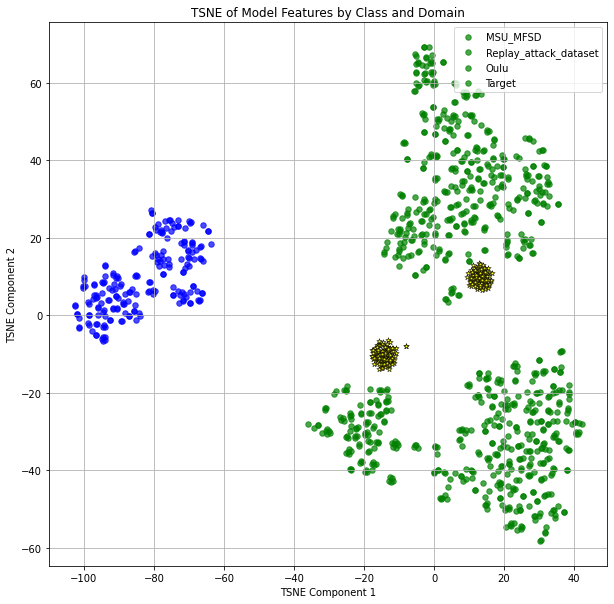

In [81]:
# رنگ‌های مختلف برای دامنه‌ها
colors = {0: 'blue', 1: 'green'}

# رسم نمودار TSNE
plt.figure(figsize=(10, 10))

# اجرای TSNE برای ویژگی‌ها
tsne = TSNE(n_components=2, random_state=0,n_iter=5000)
X_tsne = tsne.fit_transform(np.squeeze(feature_list))

# رسم نقاط براساس دامنه‌ها و لیبل‌ها
for i, (x, y, domain, label) in enumerate(zip(X_tsne, y_list, domains, y_list)):
#             if label == 0:
#                 marker = 'o'  # دایره برای کلاس 0
#             else:
#                 marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color=colors[domain], marker=marker, s=30, alpha=0.7)

# افزودن داده‌های هدف به نمودار
target_tsne = tsne.fit_transform(np.squeeze(feature_list_target))
for x, label in zip(target_tsne, y_list_target):
#     if label == 0:
#         marker = 'o'  # دایره برای کلاس 0
#     else:
#         marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color='yellow', marker='*', s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("TSNE of Model Features by Class and Domain")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(['MSU_MFSD', 'Replay_attack_dataset', 'Oulu', 'Target'], loc='upper right')
plt.grid(True)
plt.show()


/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_170530/1402750237.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring

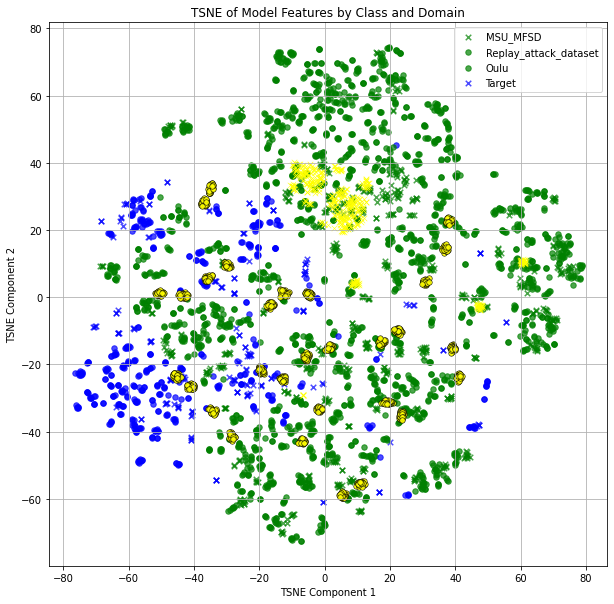

In [28]:
# رنگ‌های مختلف برای دامنه‌ها
colors = {0: 'blue', 1: 'green'}

# رسم نمودار TSNE
plt.figure(figsize=(10, 10))

for k_p in [0, 37,52] : 

        
        feature_list = a[:,k_p,:]
        feature_list_target = b[:,kp,:]



        # رسم نقاط براساس دامنه‌ها و لیبل‌ها
        for i, (x, y, domain, label) in enumerate(zip(X_tsne, y_list, domains, y_list)):
#             if label == 0:
#                 marker = 'o'  # دایره برای کلاس 0
#             else:
#                 marker = 'x'  # ضربدر برای کلاس 1
            plt.scatter(x[0], x[1], color=colors[domain], marker=marker, s=30, alpha=0.7)

        # افزودن داده‌های هدف به نمودار
        target_tsne = tsne.fit_transform(feature_list_target)
        for x, label in zip(target_tsne, y_list_target):
        #     if label == 0:
        #         marker = 'o'  # دایره برای کلاس 0
        #     else:
        #         marker = 'x'  # ضربدر برای کلاس 1
            plt.scatter(x[0], x[1], color='yellow', marker='*', s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("TSNE of Model Features by Class and Domain")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(['MSU_MFSD', 'Replay_attack_dataset', 'Oulu', 'Target'], loc='upper right')
plt.grid(True)
plt.show()


/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in T

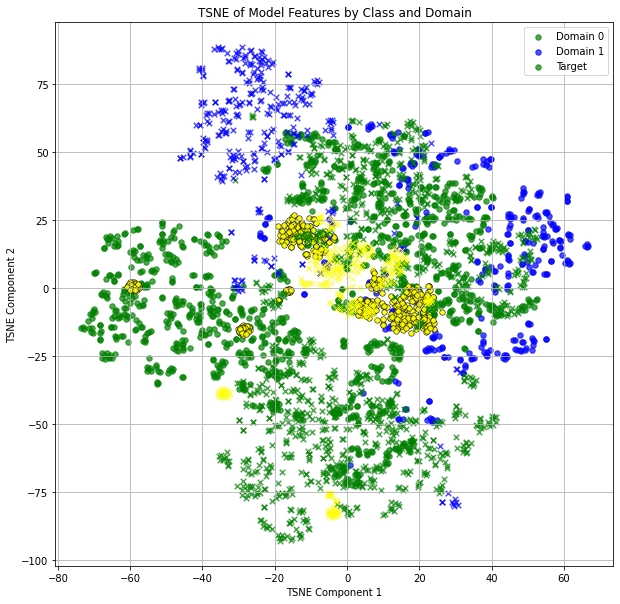

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# تعریف رنگ‌ها و مارکرها برای دامنه‌ها و مقادیر kp
colors = {0: 'blue', 1: 'green'}
markers = ['o', 'x', 's']  # به عنوان مثال: دایره، ضربدر، مربع برای مقادیر مختلف kp

# رسم نمودار TSNE
plt.figure(figsize=(10, 10))

for idx, k_p in enumerate([15, 280]):
    
    # گرفتن ویژگی‌ها و داده‌های هدف
    feature_list = a[:, k_p, :]
    feature_list_target = b[:, k_p, :]
    
    # اجرای TSNE برای ویژگی‌ها
    tsne = TSNE(n_components=2, random_state=0,n_iter=5000)
    X_tsne = tsne.fit_transform(feature_list)
    target_tsne = tsne.fit_transform(feature_list_target)
    
    # رسم نقاط براساس دامنه‌ها و لیبل‌ها
    for (x, y, domain) in zip(X_tsne, y_list, domains):
        plt.scatter(x[0], x[1], color=colors[domain], marker=markers[idx], s=30, alpha=0.7)

    # افزودن داده‌های هدف به نمودار
    for x in target_tsne:
        plt.scatter(x[0], x[1], color='yellow', marker=markers[idx], s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("TSNE of Model Features by Class and Domain")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(['Domain 0', 'Domain 1', 'Target'], loc='upper right')
plt.grid(True)
plt.show()


In [36]:
domains.shape[0]

array([1, 1, 1, ..., 1, 1, 1])

/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_170530/4217651086.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x[0], x[1], color='yellow', marker=markers[idx], s=30, edgecolor='black', linewidth=0.6, alpha=0.9)


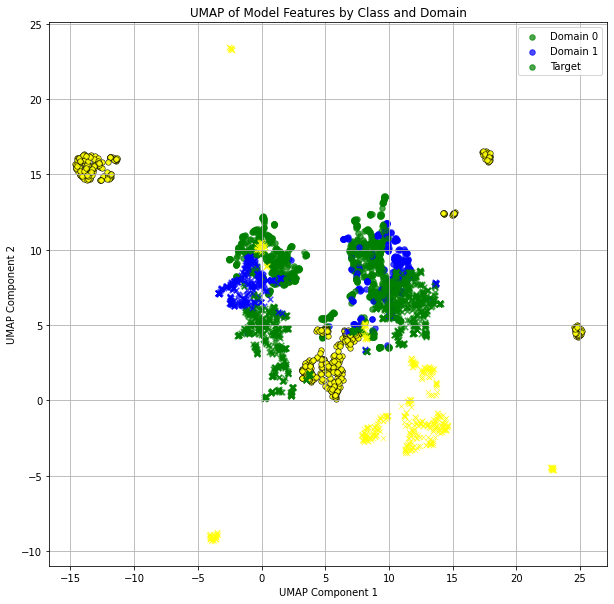

In [56]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
# تعریف رنگ‌ها و مارکرها برای دامنه‌ها و مقادیر kp
colors = {0: 'blue', 1: 'green'}
markers = ['o', 'x', 's']  # به عنوان مثال: دایره، ضربدر، مربع برای مقادیر مختلف kp

# رسم نمودار UMAP
plt.figure(figsize=(10, 10))

for idx, k_p in enumerate([15,280]):
    
    # گرفتن ویژگی‌ها و داده‌های هدف
    feature_list = a[:, k_p, :]
    feature_list_target = b[:, k_p, :]
    
    # اجرای UMAP برای ویژگی‌ها
    umap_model = umap.UMAP(n_components=2, random_state=0)
    X_umap = umap_model.fit_transform(feature_list)
    target_umap = umap_model.fit_transform(feature_list_target)
    
    # رسم نقاط براساس دامنه‌ها و لیبل‌ها
    for i, (x, y, domain) in enumerate(zip(X_umap, y_list, domains)):
        # اشکال‌زدایی: چاپ دامنه
        #print(f"Point {i}: Domain = {domain}, Color = {colors.get(domain, 'gray')}")
        
        # بررسی می‌کنیم که `domain` فقط شامل 0 و 1 باشد
        if domain in colors:
            plt.scatter(x[0], x[1], color=colors[domain], marker=markers[idx], s=30, alpha=0.7)
        else:
            # اگر دامنه ناشناخته باشد، با رنگ خاکستری نمایش داده شود
            plt.scatter(x[0], x[1], color='gray', marker=markers[idx], s=30, alpha=0.7)

    # افزودن داده‌های هدف به نمودار
    for x in target_umap:
        plt.scatter(x[0], x[1], color='yellow', marker=markers[idx], s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("UMAP of Model Features by Class and Domain")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(['Domain 0', 'Domain 1', 'Target'], loc='upper right')
plt.grid(True)
plt.show()
